##0 - Instalação WiSARD e Drive

In [ ]:
!pip install pybind11
!pip install wisardpkg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wisardpkg: filename=wisardpkg-1.6.3-cp310-cp310-linux_x86_64.whl size=3343186 sha256=970ef071a32e3c784b662e6eca4b9a93be9daa35cff1107f738bd7124062806c
  Stored in directory: /root/.cache/pip/wheels/70/a2/77/f9bafc243ca6ab4208a612d438374f3e6170563f1edeae671d
Successfully built wisardpkg


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##**1 - Processamento do Dataset**

###**1.1 - Redimensionamento, escala de cinza e binarização**

In [ ]:
%%time
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import wisardpkg as wp
from tqdm import tqdm  # Biblioteca para barra de progresso

# Caminhos dataset
data_dir = "/content/gdrive/MyDrive/datasets/ships_simpleCNN_alt"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"

# Parâmetros do modelo
input_size = (160, 160)  # Resolução para as imagens

# Binarizar imagem com base na luminância
def binarize_images_with_luminance(data):
    binarized_data = []
    for img in data:
        # Calcular luminância média da imagem
        luminance_mean = np.mean(img)
        # Binarizar: 1 se valor > média, 0 caso contrário
        binary_img = (img > luminance_mean).astype(np.uint8).flatten()
        binarized_data.append(binary_img)
    return np.array(binarized_data)

# Carregar e binarizar os dados com barra de progresso
def load_data_with_pytorch(loader, class_names):
    binary_data = []
    labels = []

    # Adicionando tqdm para monitorar progresso
    for images, batch_labels in tqdm(loader, desc="Processando Dados", unit="batch"):
        # Converte o tensor de imagens para NumPy
        images_np = images.numpy()
        # Remove a dimensão extra (grayscale channel)
        images_np = images_np.squeeze(1)
        # Binariza as imagens usando a função
        batch_binary_data = binarize_images_with_luminance(images_np)
        binary_data.append(batch_binary_data)
        # Converte índices para nomes das classes
        labels.extend([class_names[label] for label in batch_labels.numpy()])


    # Concatena todos os batches em um único array
    binary_data = np.concatenate(binary_data)
    labels = np.array(labels)

    return binary_data, labels

# Configuração de transformações (pré-processamento)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertendo para escala de cinza
    transforms.Resize(input_size),               # Redimensionando as imagens
    transforms.ToTensor(),                       # Convertendo para tensores PyTorch
])

# Carregando os dados usando PyTorch DataLoader
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=100)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=100)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=100)



CPU times: user 55.1 ms, sys: 8.24 ms, total: 63.4 ms
Wall time: 10.9 s


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Mapear classes para texto
class_names = train_dataset.classes
print("Classes:", class_names)

# Carregando os dados com barras de progresso
print("Carregando e binarizando os dados de treinamento...")
train_data, train_labels = load_data_with_pytorch(train_loader, class_names)

print("Carregando e binarizando os dados de validação...")
valid_data, valid_labels = load_data_with_pytorch(valid_loader, class_names)

print("Carregando e binarizando os dados de teste...")
test_data, test_labels = load_data_with_pytorch(test_loader, class_names)


Classes: ['Aircraft Carrier', 'Bulkers', 'Container Ship', 'Cruise', 'DDG', 'Submarine', 'Tug']
Carregando e binarizando os dados de treinamento...


Processando Dados: 100%|██████████| 5365/5365 [01:18<00:00, 68.09batch/s] 


Carregando e binarizando os dados de validação...


Processando Dados: 100%|██████████| 484/484 [00:09<00:00, 50.87batch/s]


Carregando e binarizando os dados de teste...


Processando Dados: 100%|██████████| 523/523 [00:11<00:00, 43.67batch/s] 


###**1.2 - Utilização do Kernel Canvas como alternativa**

In [ ]:
%%time
import os
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import wisardpkg as wp
from tqdm import tqdm  # Biblioteca para barra de progresso

# Caminhos dataset
data_dir = "/content/gdrive/MyDrive/datasets/ships_simpleCNN"
train_dir = f"{data_dir}/train"
valid_dir = f"{data_dir}/valid"
test_dir = f"{data_dir}/test"

# Parâmetros do modelo e Kernel Canvas
input_size = (160, 160)  # Resolução para as imagens (não será redimensionada, mas usada no KernelCanvas)
dimension = input_size[0] * input_size[1]  # Total de pixels para o Kernel Canvas
number_of_kernels = 2048  # Número de kernels gerados pelo Kernel Canvas
bits_by_kernel = 16
activation_degree = 0.075
use_direction = False

# Inicializando o Kernel Canvas
kc = wp.KernelCanvas(
    dimension,
    number_of_kernels,
    bitsBykernel=bits_by_kernel,
    activationDegree=activation_degree,
)

# Transformação para carregar e processar imagens com Kernel Canvas
def load_data_with_kernel_canvas(loader, class_names):
    binary_data = []
    labels = []

    # Adicionando tqdm para monitorar progresso
    for images, batch_labels in tqdm(loader, desc="Processando Dados", unit="batch"):
        # Converte o tensor de imagens para NumPy
        images_np = images.numpy()
        # Remove a dimensão extra (grayscale channel)
        images_np = images_np.squeeze(1)
        # Achata a imagem para vetor 1D e aplica Kernel Canvas
        for img in images_np:
            binary_img = kc.transform([img.flatten()])[0]  # Aplica o Kernel Canvas
            binary_img = np.array(binary_img)
            binary_data.append(binary_img)
        # Converte índices para nomes das classes
        labels.extend([class_names[label] for label in batch_labels.numpy()])

    # Concatena todos os batches em um único array
    binary_data = np.concatenate(binary_data)
    labels = np.array(labels)

    return binary_data, labels

# Configuração de transformações (pré-processamento)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertendo para escala de cinza
    transforms.Resize(input_size),               # Redimensionando para manter consistência de tamanho
    transforms.ToTensor(),                       # Convertendo para tensores PyTorch
])

# Carregando os dados usando PyTorch DataLoader
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=100)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=100)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=100)

# Processar os dados com Kernel Canvas
class_names = train_dataset.classes
train_data, train_labels = load_data_with_kernel_canvas(train_loader, class_names)
valid_data, valid_labels = load_data_with_kernel_canvas(valid_loader, class_names)
test_data, test_labels = load_data_with_kernel_canvas(test_loader, class_names)

# Saída dos tamanhos dos conjuntos processados
print(f"Dados de treinamento: {train_data.shape}, Labels: {train_labels.shape}")
print(f"Dados de validação: {valid_data.shape}, Labels: {valid_labels.shape}")
print(f"Dados de teste: {test_data.shape}, Labels: {test_labels.shape}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Processando Dados: 100%|██████████| 893/893 [11:02<00:00,  1.35batch/s]


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:
# Converter binary_data para uma lista de listas de inteiros
train_data = train_data.tolist()

# Converter labels para uma lista de strings
train_labels = train_labels.tolist()


##**2 - Treinamento WiSARD**

In [ ]:
%%time
address_size = 8  # Tamanho tupla WiSARD

# Criando e treinando o modelo WiSARD
print("Treinando o modelo WiSARD...")
model = wp.Wisard(address_size)
model.train(train_data, train_labels)

# Avaliando no conjunto de validação
print("Avaliando no conjunto de validação...")
valid_predictions = model.classify(valid_data)
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

Treinando o modelo WiSARD...
Avaliando no conjunto de validação...
                  precision    recall  f1-score   support

Aircraft Carrier       0.74      0.35      0.48        74
         Bulkers       0.38      0.22      0.28        23
  Container Ship       0.63      0.60      0.61        82
          Cruise       0.53      0.79      0.64        72
             DDG       0.67      0.58      0.62        84
       Submarine       0.64      0.54      0.59        72
             Tug       0.45      0.69      0.55        77

        accuracy                           0.57       484
       macro avg       0.58      0.54      0.54       484
    weighted avg       0.60      0.57      0.57       484

CPU times: user 19.9 s, sys: 155 ms, total: 20 s
Wall time: 19.6 s


In [ ]:
%%time
address_size = 16  # Tamanho tupla WiSARD

# Criando e treinando o modelo WiSARD
print("Treinando o modelo WiSARD...")
model = wp.Wisard(address_size)
model.train(train_data, train_labels)

# Avaliando no conjunto de validação
print("Avaliando no conjunto de validação...")
valid_predictions = model.classify(valid_data)
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

Treinando o modelo WiSARD...
Avaliando no conjunto de validação...
                  precision    recall  f1-score   support

Aircraft Carrier       0.59      0.58      0.59        74
         Bulkers       0.35      0.52      0.42        23
  Container Ship       0.56      0.78      0.65        82
          Cruise       0.80      0.65      0.72        72
             DDG       0.56      0.71      0.62        84
       Submarine       0.87      0.46      0.60        72
             Tug       0.62      0.47      0.53        77

        accuracy                           0.61       484
       macro avg       0.62      0.60      0.59       484
    weighted avg       0.64      0.61      0.61       484

CPU times: user 18.8 s, sys: 166 ms, total: 18.9 s
Wall time: 18.5 s


In [ ]:
%%time
address_size = 32  # Tamanho tupla WiSARD

# Criando e treinando o modelo WiSARD
print("Treinando o modelo WiSARD...")
model = wp.Wisard(address_size)
model.train(train_data, train_labels)

# Avaliando no conjunto de validação
print("Avaliando no conjunto de validação...")
valid_predictions = model.classify(valid_data)
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

Treinando o modelo WiSARD...
Avaliando no conjunto de validação...
                  precision    recall  f1-score   support

Aircraft Carrier       0.48      0.64      0.55        74
         Bulkers       0.19      0.30      0.23        23
  Container Ship       0.61      0.52      0.57        82
          Cruise       0.60      0.17      0.26        72
             DDG       0.51      0.74      0.60        84
       Submarine       0.62      0.29      0.40        72
             Tug       0.39      0.52      0.44        77

        accuracy                           0.48       484
       macro avg       0.49      0.45      0.44       484
    weighted avg       0.52      0.48      0.46       484

CPU times: user 14.6 s, sys: 105 ms, total: 14.7 s
Wall time: 14.3 s


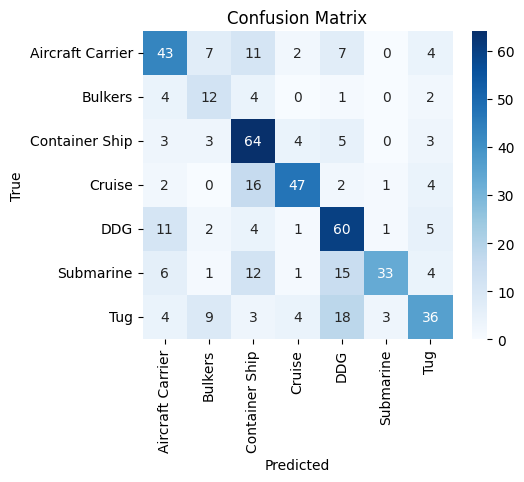

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns  # Opcional para melhor visualização

# Matriz de confusão
conf_matrix = confusion_matrix(valid_labels, valid_predictions)

# Plotando a matriz de confusão
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
%%time
# Avaliando no conjunto de teste
print("Avaliando no conjunto de teste...")
test_predictions = model.classify(test_data)
print(classification_report(test_labels, test_predictions, target_names=class_names))

Avaliando no conjunto de teste...
                  precision    recall  f1-score   support

Aircraft Carrier       0.58      0.37      0.45        59
         Bulkers       0.79      0.28      0.41        97
     Car Carrier       0.26      0.98      0.41        95
  Container Ship       0.58      0.35      0.43        86
          Cruise       0.71      0.44      0.55        45
             DDG       0.54      0.25      0.34       102
       Submarine       0.64      0.27      0.38        66
             Tug       0.43      0.22      0.29        68

        accuracy                           0.40       618
       macro avg       0.57      0.40      0.41       618
    weighted avg       0.56      0.40      0.40       618

CPU times: user 5.21 s, sys: 31.5 ms, total: 5.25 s
Wall time: 5.15 s


In [ ]:
# Matriz de confusão
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plotando a matriz de confusão
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'confusion_matrix' is not defined

In [ ]:
%%time
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np

# Configurações
num_runs = 10  # Número de execuções
address_size = 16  # Tamanho da tupla WiSARD

# Listas para armazenar métricas
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []  # Nova lista para acurácia

# Executar o treinamento e avaliação múltiplas vezes
for run in range(num_runs):
    print(f"Execução {run + 1}/{num_runs}...")

    # Criando e treinando o modelo WiSARD
    model = wp.Wisard(address_size)
    model.train(train_data, train_labels)

    # Avaliando no conjunto de validação
    valid_predictions = model.classify(valid_data)

    # Calculando métricas
    precision, recall, f1, _ = precision_recall_fscore_support(valid_labels, valid_predictions, average='weighted')
    accuracy = accuracy_score(valid_labels, valid_predictions)  # Calculando a acurácia

    # Armazenando métricas
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculando média e desvio padrão das métricas
precision_mean = np.mean(precision_scores)
precision_std = np.std(precision_scores)
recall_mean = np.mean(recall_scores)
recall_std = np.std(recall_scores)
f1_mean = np.mean(f1_scores)
f1_std = np.std(f1_scores)
accuracy_mean = np.mean(accuracy_scores)
accuracy_std = np.std(accuracy_scores)

# Exibindo resultados
print("\nResultados após " + str(num_runs) + " execuções:")
print(f"Precisão: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Revocação: {recall_mean:.4f} ± {recall_std:.4f}")
print(f"F1-Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Acurácia: {accuracy_mean:.4f} ± {accuracy_std:.4f}")  # Exibindo a acurácia


Execução 1/10...
Execução 2/10...
Execução 3/10...
Execução 4/10...
Execução 5/10...
Execução 6/10...
Execução 7/10...
Execução 8/10...
Execução 9/10...
Execução 10/10...

Resultados após 10 execuções:
Precisão: 0.6310 ± 0.0075
Revocação: 0.5913 ± 0.0080
F1-Score: 0.5900 ± 0.0087
Acurácia: 0.5913 ± 0.0080
CPU times: user 3min 6s, sys: 1.35 s, total: 3min 7s
Wall time: 3min 3s


In [ ]:
# Avaliando no conjunto de teste
print("Avaliando no conjunto de teste...")
test_predictions = model.classify(test_data)
print(classification_report(test_labels, test_predictions, target_names=class_names))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Carregando e binarizando os dados de teste...


Processando Dados: 100%|██████████| 618/618 [00:05<00:00, 108.77batch/s]


Avaliando no conjunto de teste...
                  precision    recall  f1-score   support

Aircraft Carrier       0.60      0.41      0.48        59
         Bulkers       0.76      0.29      0.42        97
     Car Carrier       0.26      0.98      0.41        95
  Container Ship       0.52      0.33      0.40        86
          Cruise       0.71      0.38      0.49        45
             DDG       0.53      0.24      0.33       102
       Submarine       0.66      0.29      0.40        66
             Tug       0.48      0.24      0.32        68

        accuracy                           0.40       618
       macro avg       0.56      0.39      0.41       618
    weighted avg       0.55      0.40      0.40       618



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 100 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Carregando e binarizando os dados de teste...


Processando Dados: 100%|██████████| 618/618 [00:08<00:00, 75.72batch/s] 


Avaliando no conjunto de teste...
                  precision    recall  f1-score   support

Aircraft Carrier       0.62      0.41      0.49        74
         Bulkers       0.62      0.22      0.32        23
     Car Carrier       0.49      0.98      0.65       179
  Container Ship       0.69      0.45      0.54        82
          Cruise       0.84      0.38      0.52        72
             DDG       0.59      0.64      0.61        84
       Submarine       0.85      0.40      0.55        72
             Tug       0.71      0.32      0.45        77

        accuracy                           0.58       663
       macro avg       0.68      0.47      0.52       663
    weighted avg       0.65      0.58      0.55       663



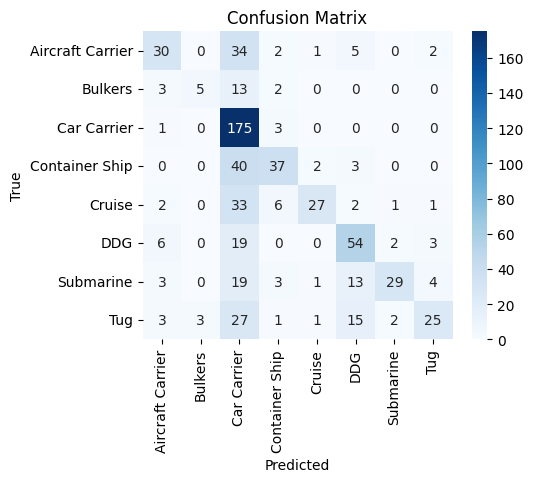

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns  # Opcional para melhor visualização

# Carregando os dados de teste
test_dir = f"{data_dir}/test"
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=100)

print("Carregando e binarizando os dados de teste...")
test_data, test_labels = load_data_with_pytorch(test_loader, class_names)

# Avaliando no conjunto de teste
print("Avaliando no conjunto de teste...")
#test_predictions = model.classify(test_data)
valid_predictions = model.classify(valid_data)


# Relatório de classificação
print(classification_report(valid_labels, valid_predictions, target_names=class_names))

# Matriz de confusão
conf_matrix = confusion_matrix(valid_labels, valid_predictions)

# Plotando a matriz de confusão
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

###Fc pra mostrar imagens em cinza e binarizadas

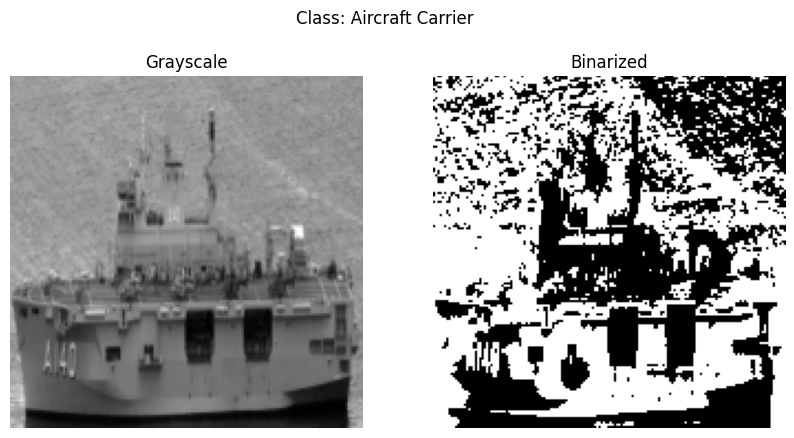

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image

# Função para binarizar uma imagem
def binarize_image(data):
    binarized_data = []
    for img in data:
        # Calcular luminância média da imagem
        luminance_mean = np.mean(img)
        # Binarizar: 1 se valor > média, 0 caso contrário
        binary_img = (img > luminance_mean).astype(np.uint8).flatten()
        binarized_data.append(binary_img)
    return np.array(binarized_data)

# Função para exibir a imagem original, grayscale e binarizada
def show_image_transformations(dataset, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)  # Escolher índice aleatório

    # Carregar a imagem original e o rótulo
    original_img, label = dataset[idx]

    # Converter para formato adequado (PIL -> NumPy para visualização)
    if isinstance(original_img, torch.Tensor):
        original_img = ToPILImage()(original_img)  # Garantir formato correto
    original_img_np = np.array(original_img)  # A imagem PIL convertida para NumPy

    # Criar a imagem grayscale
    grayscale_img = ToTensor()(original_img).squeeze(0).numpy()

    # Binarizar a imagem
    binarized_img = binarize_image(grayscale_img)

    # Plotar as imagens
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Imagem Grayscale
    axs[0].imshow(grayscale_img, cmap='gray')
    axs[0].set_title("Grayscale")
    axs[0].axis("off")

    # Imagem Binarizada
    axs[1].imshow(binarized_img, cmap='gray')
    axs[1].set_title("Binarized")
    axs[1].axis("off")

    plt.suptitle(f"Class: {dataset.classes[label]}")
    plt.show()


# Configuração de transformações (pré-processamento)
transform1 = transforms.Compose([
   transforms.Grayscale(num_output_channels=1),  # Convertendo para cinza
    transforms.Resize(input_size),               # Redimensionando as imagens
    transforms.ToTensor(),                       # Convertendo para tensores
])

# Carregando os dados usando PyTorch DataLoader
train_dataset1 = datasets.ImageFolder(train_dir, transform=transform1)

# Exemplo de uso
show_image_transformations(train_dataset1, idx=12)

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd

def analyze_image_resolutions(folder_path):
    # Inicializa listas para armazenar larguras e alturas
    widths = []
    heights = []

    # Itera sobre os arquivos da pasta
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            # Caminho completo da imagem
            file_path = os.path.join(folder_path, filename)

            # Abre a imagem
            with Image.open(file_path) as img:
                # Coleta largura e altura
                widths.append(img.width)
                heights.append(img.height)

    # Converte listas em arrays NumPy para facilitar os cálculos
    widths = np.array(widths)
    heights = np.array(heights)
    resolutions = widths * heights  # Calcula a resolução em pixels

    # Calcula as estatísticas
    mean_width = widths.mean()
    min_width = widths.min()
    max_width = widths.max()

    mean_height = heights.mean()
    min_height = heights.min()
    max_height = heights.max()

    mean_resolution = resolutions.mean()
    min_resolution = resolutions.min()
    max_resolution = resolutions.max()

    # Cria um DataFrame com as estatísticas
    data = {
        'Métrica': ['Largura', 'Altura', 'Resolução (Largura x Altura)'],
        'Média': [mean_width, mean_height, mean_resolution],
        'Mínimo': [min_width, min_height, min_resolution],
        'Máximo': [max_width, max_height, max_resolution]
    }
    stats_df = pd.DataFrame(data)

    return stats_df

# Caminho da pasta com as imagens
folder_path = "/content/gdrive/MyDrive/datasets/pokemons/train/Pikachu"

# Analisar resoluções das imagens
resolution_stats_df = analyze_image_resolutions(folder_path)

# Exibir os resultados
print(resolution_stats_df)

# Salvar os resultados em um arquivo CSV
resolution_stats_df.to_csv("estatisticas_resolucao_imagens.csv", index=False)


                        Métrica     Média  Mínimo  Máximo
0                       Largura     640.0     640     640
1                        Altura     640.0     640     640
2  Resolução (Largura x Altura)  409600.0  409600  409600


###Calculando tamanho final do modelo

In [ ]:
import json
import sys

# Obtendo a configuração JSON do modelo
model_json = model.json()

# Convertendo para string JSON
model_json_str = json.dumps(model_json)

# Calculando o tamanho em memória
model_size_bytes = sys.getsizeof(model_json_str)

# Imprimindo o tamanho do modelo
print(f"Tamanho do modelo em memória: {model_size_bytes} bytes")

# Opcional: salvar o JSON em um arquivo para medir o tamanho no disco
with open("model_config.json", "w") as file:
    file.write(model_json_str)

import os
file_size = os.path.getsize("model_config.json")
print(f"Tamanho do modelo no disco: {file_size} bytes")

# Remover o arquivo, se necessário
os.remove("model_config.json")

Tamanho do modelo em memória: 72283945 bytes
Tamanho do modelo no disco: 72283896 bytes


###Usando KernelCanvas para processar as imagens

In [ ]:
# Configuração do KernelCanvas
dimension = 25600  #
number_of_kernels = 100  # Número de kernels desejado
bits_by_kernel = 3
activation_degree = 0.07
use_direction = False

# Criar o KernelCanvas
kc = KernelCanvas(
    dimension=dimension,  # A entrada será linearizada
    numberOfKernels=number_of_kernels,
    bitsBykernel=bits_by_kernel,
    activationDegree=activation_degree,
    useDirection=use_direction
)

# Diretório com imagens de entrada
input_directory = "path/to/your/input_images"

# Carregar as imagens como vetores
image_vectors = load_images_to_vectors(input_directory, dimension)

# Aplicar o KernelCanvas para transformar os vetores
transformed_data = [kc.transform([vector]) for vector in image_vectors]

# Exemplo de saída transformada
print("Dados transformados para WiSARD:")
print(transformed_data[0])  # Imprime o vetor binário transformado para a primeira imagem